# Stacking

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from common import TARGET, OBESITY_TYPES, DATASET_PATH, RANGE_INDEXES

# load dataset

dataset = pd.read_csv(DATASET_PATH)

# round to nearest integer for ranges
dataset[RANGE_INDEXES] = dataset[RANGE_INDEXES].apply(round).astype(np.int64)


X = dataset.drop(TARGET, axis="columns")
y = dataset[TARGET].map(
    {type: i for i, type in enumerate(OBESITY_TYPES)}
)  # transform targets into numbers


# split test/train (80%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=100429021
)

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from common import flatten


CATEGORICAL_FEATURES = [
    (
        ["CAEC", "CALC"],  # indexes
        ["no", "Sometimes", "Frequently", "Always"],  # values
    ),
    (
        ["family_history_with_overweight", "FAVC", "SMOKE", "SCC"],
        ["yes", "no"],
    ),
    (["Gender"], ["Male", "Female"]),
    (
        ["MTRANS"],
        [
            "Automobile",
            "Motorbike",
            "Public_Transportation",
            "Walking",
            "Bike",
        ],
    ),
]


preprocessor = ColumnTransformer(
    transformers=[
        (
            "numeric",
            StandardScaler(),
            [
                "Age",
                "Height",
                "Weight",
                "FCVC",
                "NCP",
                "CH2O",
                "FAF",
                "TUE",
            ],
        ),
        (
            "categorical",
            OneHotEncoder(
                categories=list(
                    # python magic here
                    flatten(
                        [
                            [vals for _ in range(len(feats))]
                            for feats, vals in CATEGORICAL_FEATURES
                        ]
                    )
                )
            ),
            list(flatten([feats for feats, _ in CATEGORICAL_FEATURES])),
        ),
    ]
)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "cls",
            StackingClassifier(
                estimators=[
                    (
                        "lr",
                        LogisticRegression(
                            max_iter=10**4,
                            random_state=100429021,
                            C=10,
                            penalty="l1",
                            solver="saga",
                        ),
                    ),
                    ("svm", SVC(C=10, kernel="linear")),
                    (
                        "xb",
                        XGBClassifier(
                            eval_metric=f1_score,
                            learning_rate=0.2,
                            max_depth=3,
                            n_estimators=200,
                        ),
                    ),
                ],
                final_estimator=LogisticRegression(max_iter=10**4),
                cv=5,
            ),
        ),
    ]
)

Training took 36.373 s

Results:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        87
           1       0.97      0.94      0.96        81
           2       0.94      0.94      0.94        85
           3       0.94      0.95      0.94        78
           4       0.98      0.97      0.98       113
           5       0.98      1.00      0.99        92
           6       1.00      1.00      1.00        98

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634

F1 score: 0.9699583864362967


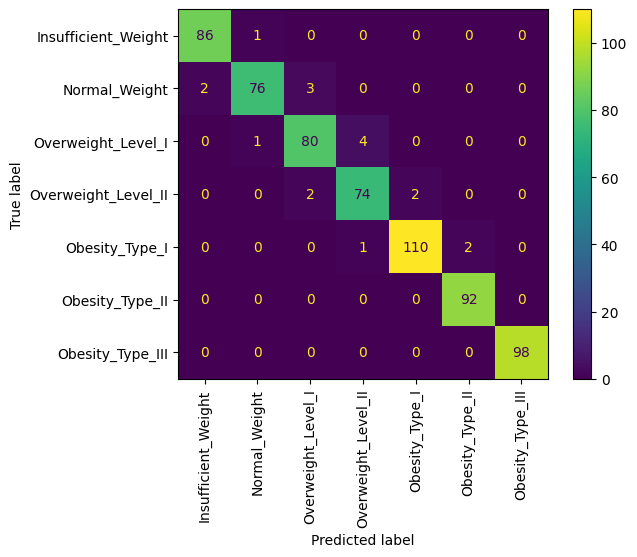

In [ ]:
from time import perf_counter_ns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


# train
tic = perf_counter_ns()
pipeline.fit(X_train, y_train)
time = perf_counter_ns() - tic

print(f"Training took {10**-9 * time:.3f} s")

# test
y_pred = pipeline.predict(X_test)

print("\nResults:")
print(classification_report(y_test, y_pred))
score = f1_score(y_test, y_pred, average="macro")
print("F1 score:", score)

cm = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=OBESITY_TYPES, xticks_rotation="vertical"
)
cm.figure_.savefig(
    "../report/img/cm_Stacking.svg", bbox_inches="tight"
)  # store

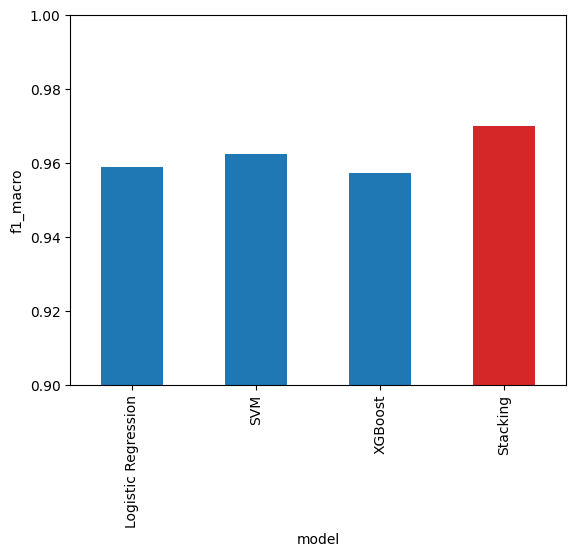

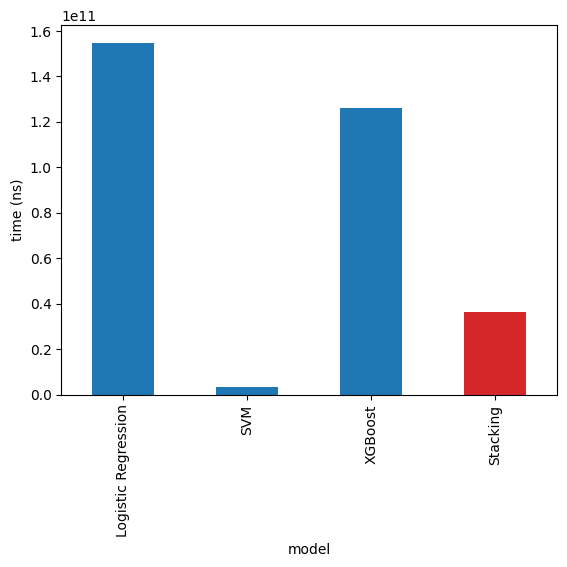

In [10]:
import matplotlib.pyplot as plt


# compare results

results = pd.read_csv("../data/results.csv")
results = pd.concat(
    [
        results[
            results["model"].isin(["Logistic Regression", "SVM", "XGBoost"])
        ],
        pd.DataFrame(
            {"model": ["Stacking"], "f1_macro": [score], "time": [time]}
        ),
    ]
)

# score
results.plot.bar(
    x="model",
    y="f1_macro",
    ylabel="f1_macro",
    legend=False,
    ylim=[0.9, 1],
    color=["tab:blue", "tab:blue", "tab:blue", "tab:red"],
)
plt.savefig("../report/img/stacking_result.svg", bbox_inches="tight")


# time

results.plot.bar(
    x="model",
    y="time",
    ylabel="time (ns)",
    legend=False,
    color=["tab:blue", "tab:blue", "tab:blue", "tab:red"],
)
plt.savefig("../report/img/stacking_time.svg", bbox_inches="tight")